In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_18053/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


In [3]:
params = {'a': 2}
def printing(a):
    print(a)
printing(**params)

2


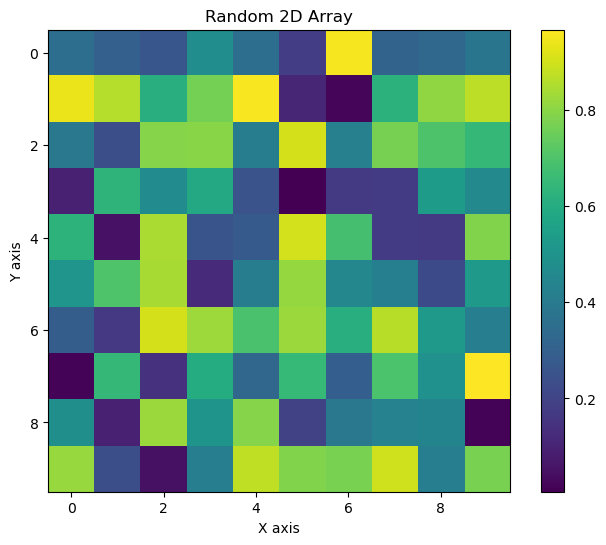

In [4]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [5]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                 
                    e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    args_gpu = None
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        args_gpu = args.gpu
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)

    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc_best = 0
    val_acc_now = 0
    elapsed_time_val = 0
    no_val_best_growth_count = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if (e_transport_swap > 0 and no_val_best_growth_count == e_transport_swap):
            net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
            no_val_best_growth_count = 0

        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################
                        
            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################
                        
                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                val_loss_temp = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += val_loss_temp.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc_best < val_acc_now:
                    val_acc_best = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
                    no_val_best_growth_count = 0
                else:
                    no_val_best_growth_count = no_val_best_growth_count + 1
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc_best:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc_best})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [6]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5
const2 = False # trace 할거면 True, 안할거면 False

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

if const2 == True:
    const2 = decay
else:
    const2 = 0.0

wandb.init(project= f'my_snn {unique_name}',save_code=True)

my_snn_system(  devices = "3",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 34, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'NMNIST_TONIC',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',512],
                # cfg = ['M','M',200,200],
                cfg = [200,200],
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = 0.009, # 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'hard_sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle' 'hard_sigmoid'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = 1, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = 5_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = True, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                 
                e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# DDP 실행 코드
'''
ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
'''


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): DimChanger_for_FC_sstep()
      (1): SYNAPSE_FC_trace_sstep()
      (2): LIF_layer_trace_sstep()
      (3): Feedback_Receiver()
      (4): SYNAPSE_FC_trace_sstep()
      (5): LIF_layer_trace_sstep()
      (6): Feedback_Receiver()
      (7): SYNAPSE_FC_trace_sstep()
      (DFA_top): Top_Gradient()
    )
  )
)
My Num of PARAMS: 504,810, system's param_num : 504,810
Memory: 1.93MiB at 32-bit
EPOCH 0


0-468/469 iter:92.71%, lr=['0.009'], iter_loss:4.569736480712891, tr:86.80%, val:94.85%, val_best:94.85%: 100%|██████████| 469/469 [09:33<00:00,  1.22s/it]

epoch_time: 573.5364577770233 seconds

EPOCH 1



1-468/469 iter:95.83%, lr=['0.008999753262144803'], iter_loss:2.885075569152832, tr:95.03%, val:95.86%, val_best:95.86%: 100%|██████████| 469/469 [01:06<00:00,  7.09it/s]  

epoch_time: 66.27748322486877 seconds

EPOCH 2



2-468/469 iter:95.83%, lr=['0.008999013075636804'], iter_loss:2.6654460430145264, tr:96.26%, val:96.28%, val_best:96.28%: 100%|██████████| 469/469 [01:06<00:00,  7.06it/s] 

epoch_time: 66.59443521499634 seconds

EPOCH 3



3-468/469 iter:98.96%, lr=['0.008997779521645792'], iter_loss:1.6232903003692627, tr:96.79%, val:96.80%, val_best:96.80%: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s] 

epoch_time: 65.91788506507874 seconds

EPOCH 4



4-468/469 iter:98.96%, lr=['0.008996052735444862'], iter_loss:1.6615947484970093, tr:97.17%, val:97.22%, val_best:97.22%: 100%|██████████| 469/469 [01:03<00:00,  7.34it/s] 

epoch_time: 64.03648376464844 seconds

EPOCH 5



5-468/469 iter:96.88%, lr=['0.008993832906395582'], iter_loss:2.3652241230010986, tr:97.43%, val:97.34%, val_best:97.34%: 100%|██████████| 469/469 [01:07<00:00,  7.00it/s] 

epoch_time: 67.17341923713684 seconds

EPOCH 6



6-468/469 iter:98.96%, lr=['0.008991120277927223'], iter_loss:1.7333320379257202, tr:97.72%, val:97.49%, val_best:97.49%: 100%|██████████| 469/469 [01:05<00:00,  7.19it/s] 

epoch_time: 65.32706546783447 seconds

EPOCH 7



7-468/469 iter:100.00%, lr=['0.00898791514751006'], iter_loss:1.444347620010376, tr:97.95%, val:97.55%, val_best:97.55%: 100%|██████████| 469/469 [01:05<00:00,  7.14it/s] 

epoch_time: 65.8009946346283 seconds

EPOCH 8



8-468/469 iter:96.88%, lr=['0.00898421786662277'], iter_loss:1.9477999210357666, tr:98.06%, val:97.52%, val_best:97.55%: 100%|██████████| 469/469 [01:05<00:00,  7.12it/s] 

epoch_time: 66.0009093284607 seconds

EPOCH 9



9-468/469 iter:98.96%, lr=['0.008980028840713859'], iter_loss:1.10595703125, tr:98.19%, val:97.63%, val_best:97.63%: 100%|██████████| 469/469 [01:05<00:00,  7.19it/s]      

epoch_time: 65.33349609375 seconds

EPOCH 10



10-468/469 iter:97.92%, lr=['0.00897534852915723'], iter_loss:1.9253170490264893, tr:98.28%, val:97.87%, val_best:97.87%: 100%|██████████| 469/469 [01:05<00:00,  7.17it/s] 

epoch_time: 65.54033637046814 seconds

EPOCH 11



11-468/469 iter:100.00%, lr=['0.008970177445201783'], iter_loss:0.7720486521720886, tr:98.40%, val:97.88%, val_best:97.88%: 100%|██████████| 469/469 [01:05<00:00,  7.16it/s]

epoch_time: 65.63576030731201 seconds

EPOCH 12



12-468/469 iter:98.96%, lr=['0.008964516155915151'], iter_loss:0.8401922583580017, tr:98.53%, val:97.93%, val_best:97.93%: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s] 

epoch_time: 65.92685389518738 seconds

EPOCH 13



13-468/469 iter:100.00%, lr=['0.008958365282121496'], iter_loss:1.1443153619766235, tr:98.62%, val:97.68%, val_best:97.93%: 100%|██████████| 469/469 [01:13<00:00,  6.34it/s]

epoch_time: 74.13671374320984 seconds

EPOCH 14



14-468/469 iter:100.00%, lr=['0.008951725498333446'], iter_loss:1.1010191440582275, tr:98.68%, val:97.99%, val_best:97.99%: 100%|██████████| 469/469 [01:18<00:00,  6.00it/s]

epoch_time: 78.28835678100586 seconds

EPOCH 15



15-468/469 iter:98.96%, lr=['0.008944597532678119'], iter_loss:1.2704331874847412, tr:98.75%, val:97.74%, val_best:97.99%: 100%|██████████| 469/469 [01:09<00:00,  6.73it/s] 

epoch_time: 69.8325400352478 seconds

EPOCH 16



16-468/469 iter:98.96%, lr=['0.008936982166817271'], iter_loss:1.078189492225647, tr:98.79%, val:98.03%, val_best:98.03%: 100%|██████████| 469/469 [01:06<00:00,  7.06it/s]   

epoch_time: 66.56729578971863 seconds

EPOCH 17



17-468/469 iter:97.92%, lr=['0.008928880235861586'], iter_loss:1.4136708974838257, tr:98.89%, val:98.09%, val_best:98.09%: 100%|██████████| 469/469 [01:05<00:00,  7.18it/s]  

epoch_time: 65.46994090080261 seconds

EPOCH 18



18-468/469 iter:100.00%, lr=['0.008920292628279097'], iter_loss:1.085507869720459, tr:98.94%, val:98.13%, val_best:98.13%: 100%|██████████| 469/469 [01:05<00:00,  7.20it/s] 

epoch_time: 65.25314855575562 seconds

EPOCH 19



19-468/469 iter:100.00%, lr=['0.008911220285797746'], iter_loss:0.9081866145133972, tr:98.95%, val:98.11%, val_best:98.13%: 100%|██████████| 469/469 [01:04<00:00,  7.30it/s]

epoch_time: 64.36325454711914 seconds

EPOCH 20



20-468/469 iter:98.96%, lr=['0.008901664203302122'], iter_loss:0.8860350847244263, tr:99.00%, val:98.17%, val_best:98.17%: 100%|██████████| 469/469 [01:04<00:00,  7.26it/s]  

epoch_time: 64.77181482315063 seconds

EPOCH 21



21-468/469 iter:98.96%, lr=['0.00889162542872436'], iter_loss:1.6140854358673096, tr:99.06%, val:98.08%, val_best:98.17%: 100%|██████████| 469/469 [01:05<00:00,  7.17it/s] 

epoch_time: 65.59956502914429 seconds

EPOCH 22



22-468/469 iter:98.96%, lr=['0.008881105062929218'], iter_loss:1.3077170848846436, tr:99.11%, val:98.18%, val_best:98.18%: 100%|██████████| 469/469 [01:06<00:00,  7.08it/s] 

epoch_time: 66.40808415412903 seconds

EPOCH 23



23-468/469 iter:97.92%, lr=['0.00887010425959336'], iter_loss:1.2512563467025757, tr:99.14%, val:98.27%, val_best:98.27%: 100%|██████████| 469/469 [01:06<00:00,  7.03it/s]  

epoch_time: 66.81559109687805 seconds

EPOCH 24



24-468/469 iter:100.00%, lr=['0.008858624225078836'], iter_loss:0.7812573313713074, tr:99.22%, val:98.09%, val_best:98.27%: 100%|██████████| 469/469 [01:06<00:00,  7.01it/s] 

epoch_time: 67.07347011566162 seconds

EPOCH 25



25-468/469 iter:100.00%, lr=['0.008846666218300804'], iter_loss:0.8451350331306458, tr:99.23%, val:98.23%, val_best:98.27%: 100%|██████████| 469/469 [01:06<00:00,  7.04it/s]

epoch_time: 66.78023266792297 seconds

EPOCH 26



26-468/469 iter:97.92%, lr=['0.008834231550589459'], iter_loss:1.4895472526550293, tr:99.28%, val:98.28%, val_best:98.28%: 100%|██████████| 469/469 [01:06<00:00,  7.10it/s] 

epoch_time: 66.19811058044434 seconds

EPOCH 27



27-468/469 iter:100.00%, lr=['0.008821321585546242'], iter_loss:0.993434488773346, tr:99.32%, val:98.22%, val_best:98.28%: 100%|██████████| 469/469 [01:05<00:00,  7.15it/s]  

epoch_time: 65.72442579269409 seconds

EPOCH 28



28-468/469 iter:100.00%, lr=['0.0088079377388943'], iter_loss:0.32859185338020325, tr:99.31%, val:98.15%, val_best:98.28%: 100%|██████████| 469/469 [01:06<00:00,  7.10it/s]

epoch_time: 66.17582392692566 seconds

EPOCH 29



29-468/469 iter:97.92%, lr=['0.008794081478323244'], iter_loss:1.3316102027893066, tr:99.35%, val:98.39%, val_best:98.39%: 100%|██████████| 469/469 [01:06<00:00,  7.02it/s]  

epoch_time: 67.00686645507812 seconds

EPOCH 30



30-468/469 iter:100.00%, lr=['0.00877975432332819'], iter_loss:0.7369372844696045, tr:99.36%, val:98.33%, val_best:98.39%: 100%|██████████| 469/469 [01:06<00:00,  7.01it/s] 

epoch_time: 67.00488018989563 seconds

EPOCH 31



31-468/469 iter:100.00%, lr=['0.008764957845043135'], iter_loss:0.49087634682655334, tr:99.43%, val:98.27%, val_best:98.39%: 100%|██████████| 469/469 [01:15<00:00,  6.25it/s]

epoch_time: 75.18259501457214 seconds

EPOCH 32



32-468/469 iter:97.92%, lr=['0.008749693666068665'], iter_loss:1.2761414051055908, tr:99.42%, val:98.30%, val_best:98.39%: 100%|██████████| 469/469 [14:08<00:00,  1.81s/it]  

epoch_time: 848.3401625156403 seconds

EPOCH 33



33-468/469 iter:100.00%, lr=['0.008733963460294014'], iter_loss:0.35618382692337036, tr:99.46%, val:98.31%, val_best:98.39%: 100%|██████████| 469/469 [01:07<00:00,  6.99it/s]

epoch_time: 67.26103281974792 seconds

EPOCH 34



34-468/469 iter:96.88%, lr=['0.008717768952713511'], iter_loss:1.8209048509597778, tr:99.48%, val:98.24%, val_best:98.39%: 100%|██████████| 469/469 [01:05<00:00,  7.18it/s]  

epoch_time: 65.41108512878418 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 35



35-468/469 iter:100.00%, lr=['0.008701111919237406'], iter_loss:0.5218524932861328, tr:99.48%, val:98.27%, val_best:98.39%: 100%|██████████| 469/469 [01:04<00:00,  7.28it/s] 

epoch_time: 64.54372119903564 seconds

EPOCH 36



36-468/469 iter:97.92%, lr=['0.008683994186497129'], iter_loss:1.098638892173767, tr:99.51%, val:98.27%, val_best:98.39%: 100%|██████████| 469/469 [01:04<00:00,  7.28it/s]   

epoch_time: 64.58991169929504 seconds

EPOCH 37



37-468/469 iter:100.00%, lr=['0.008666417631644975'], iter_loss:1.2852587699890137, tr:99.55%, val:98.39%, val_best:98.39%: 100%|██████████| 469/469 [01:03<00:00,  7.43it/s] 

epoch_time: 63.291157722473145 seconds

EPOCH 38



38-468/469 iter:100.00%, lr=['0.008648384182148252'], iter_loss:0.624522864818573, tr:99.56%, val:98.31%, val_best:98.39%: 100%|██████████| 469/469 [01:05<00:00,  7.16it/s]  

epoch_time: 65.64876675605774 seconds

EPOCH 39



39-468/469 iter:98.96%, lr=['0.008629895815577915'], iter_loss:0.943584144115448, tr:99.57%, val:98.38%, val_best:98.39%: 100%|██████████| 469/469 [01:07<00:00,  6.91it/s]   

epoch_time: 67.95873951911926 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 40



40-468/469 iter:97.92%, lr=['0.008610954559391704'], iter_loss:0.9375344514846802, tr:99.65%, val:98.37%, val_best:98.39%: 100%|██████████| 469/469 [01:07<00:00,  6.99it/s]  

epoch_time: 67.21724200248718 seconds

EPOCH 41



41-468/469 iter:98.96%, lr=['0.008591562490711808'], iter_loss:0.9477745294570923, tr:99.64%, val:98.37%, val_best:98.39%: 100%|██████████| 469/469 [01:07<00:00,  6.93it/s]  

epoch_time: 67.83653163909912 seconds

EPOCH 42



42-468/469 iter:98.96%, lr=['0.008571721736097089'], iter_loss:0.9793070554733276, tr:99.62%, val:98.42%, val_best:98.42%: 100%|██████████| 469/469 [01:07<00:00,  6.92it/s]  

epoch_time: 67.88932466506958 seconds

EPOCH 43



43-468/469 iter:100.00%, lr=['0.008551434471309871'], iter_loss:0.4057652950286865, tr:99.66%, val:98.44%, val_best:98.44%: 100%|██████████| 469/469 [01:06<00:00,  7.04it/s] 

epoch_time: 66.74422311782837 seconds

EPOCH 44



44-468/469 iter:100.00%, lr=['0.008530702921077358'], iter_loss:1.1309797763824463, tr:99.65%, val:98.41%, val_best:98.44%: 100%|██████████| 469/469 [01:06<00:00,  7.01it/s] 

epoch_time: 67.00616931915283 seconds

EPOCH 45



45-468/469 iter:98.96%, lr=['0.008509529358847655'], iter_loss:1.0039557218551636, tr:99.64%, val:98.40%, val_best:98.44%: 100%|██████████| 469/469 [01:07<00:00,  6.97it/s]  

epoch_time: 67.4366180896759 seconds

EPOCH 46



46-468/469 iter:100.00%, lr=['0.008487916106540466'], iter_loss:0.7855366468429565, tr:99.62%, val:98.35%, val_best:98.44%: 100%|██████████| 469/469 [01:07<00:00,  6.90it/s] 

epoch_time: 68.12578082084656 seconds

EPOCH 47



47-468/469 iter:98.96%, lr=['0.008465865534292464'], iter_loss:0.7130264043807983, tr:99.66%, val:98.34%, val_best:98.44%: 100%|██████████| 469/469 [01:07<00:00,  6.98it/s]  

epoch_time: 67.38311195373535 seconds

EPOCH 48



48-468/469 iter:100.00%, lr=['0.008443380060197386'], iter_loss:0.5396423935890198, tr:99.67%, val:98.32%, val_best:98.44%: 100%|██████████| 469/469 [01:06<00:00,  7.04it/s] 

epoch_time: 66.70268750190735 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 49



49-468/469 iter:100.00%, lr=['0.008420462150040853'], iter_loss:0.42760205268859863, tr:99.64%, val:98.33%, val_best:98.44%: 100%|██████████| 469/469 [01:06<00:00,  7.02it/s]

epoch_time: 66.94529795646667 seconds

EPOCH 50



50-468/469 iter:98.96%, lr=['0.008397114317029974'], iter_loss:0.8782116770744324, tr:99.65%, val:98.46%, val_best:98.46%: 100%|██████████| 469/469 [01:07<00:00,  6.94it/s]  

epoch_time: 67.74882698059082 seconds

EPOCH 51



51-468/469 iter:98.96%, lr=['0.008373339121517746'], iter_loss:1.1909406185150146, tr:99.67%, val:98.46%, val_best:98.46%: 100%|██████████| 469/469 [01:08<00:00,  6.88it/s]  

epoch_time: 68.34710168838501 seconds

EPOCH 52



52-468/469 iter:100.00%, lr=['0.008349139170722279'], iter_loss:0.9079509973526001, tr:99.70%, val:98.45%, val_best:98.46%: 100%|██████████| 469/469 [01:08<00:00,  6.81it/s] 

epoch_time: 68.99219512939453 seconds

EPOCH 53



53-468/469 iter:98.96%, lr=['0.008324517118440887'], iter_loss:0.7339377403259277, tr:99.71%, val:98.46%, val_best:98.46%: 100%|██████████| 469/469 [01:06<00:00,  7.02it/s]  

epoch_time: 66.94415831565857 seconds

EPOCH 54



54-468/469 iter:98.96%, lr=['0.008299475664759068'], iter_loss:0.6514438390731812, tr:99.70%, val:98.45%, val_best:98.46%: 100%|██████████| 469/469 [01:07<00:00,  6.93it/s]  

epoch_time: 67.83484959602356 seconds

EPOCH 55



55-468/469 iter:98.96%, lr=['0.008274017555754408'], iter_loss:0.8853219747543335, tr:99.72%, val:98.45%, val_best:98.46%: 100%|██████████| 469/469 [01:07<00:00,  6.96it/s]  

epoch_time: 67.53036069869995 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 56



56-468/469 iter:100.00%, lr=['0.008248145583195447'], iter_loss:0.33456316590309143, tr:99.77%, val:98.41%, val_best:98.46%: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s]

epoch_time: 65.94830989837646 seconds

EPOCH 57



57-468/469 iter:100.00%, lr=['0.008221862584235526'], iter_loss:0.47450482845306396, tr:99.78%, val:98.46%, val_best:98.46%: 100%|██████████| 469/469 [01:07<00:00,  6.94it/s]

epoch_time: 67.65228724479675 seconds

EPOCH 58



58-468/469 iter:100.00%, lr=['0.008195171441101667'], iter_loss:0.6349270939826965, tr:99.79%, val:98.41%, val_best:98.46%: 100%|██████████| 469/469 [01:07<00:00,  6.95it/s] 

epoch_time: 67.64714884757996 seconds

EPOCH 59



59-468/469 iter:100.00%, lr=['0.008168075080778492'], iter_loss:0.8598429560661316, tr:99.78%, val:98.34%, val_best:98.46%: 100%|██████████| 469/469 [01:06<00:00,  7.02it/s] 

epoch_time: 66.90801239013672 seconds

EPOCH 60



60-468/469 iter:100.00%, lr=['0.008140576474687262'], iter_loss:0.5223608613014221, tr:99.78%, val:98.39%, val_best:98.46%: 100%|██████████| 469/469 [01:07<00:00,  7.00it/s] 

epoch_time: 67.17713689804077 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 61



61-468/469 iter:98.96%, lr=['0.008112678638360014'], iter_loss:0.864262044429779, tr:99.76%, val:98.41%, val_best:98.46%: 100%|██████████| 469/469 [01:06<00:00,  7.00it/s]   

epoch_time: 67.09580516815186 seconds

EPOCH 62



62-468/469 iter:100.00%, lr=['0.008084384631108882'], iter_loss:0.7051899433135986, tr:99.74%, val:98.46%, val_best:98.46%: 100%|██████████| 469/469 [01:08<00:00,  6.86it/s] 

epoch_time: 68.53936553001404 seconds

EPOCH 63



63-468/469 iter:100.00%, lr=['0.008055697555690605'], iter_loss:0.7976316809654236, tr:99.78%, val:98.35%, val_best:98.46%: 100%|██████████| 469/469 [01:07<00:00,  6.96it/s] 

epoch_time: 67.62527871131897 seconds

EPOCH 64



64-468/469 iter:98.96%, lr=['0.008026620557966279'], iter_loss:0.7423077821731567, tr:99.79%, val:98.37%, val_best:98.46%: 100%|██████████| 469/469 [01:06<00:00,  7.00it/s]  

epoch_time: 67.09855318069458 seconds

EPOCH 65



65-468/469 iter:100.00%, lr=['0.007997156826556369'], iter_loss:0.41653233766555786, tr:99.80%, val:98.47%, val_best:98.47%: 100%|██████████| 469/469 [01:07<00:00,  6.93it/s]

epoch_time: 67.80477142333984 seconds

EPOCH 66



66-468/469 iter:100.00%, lr=['0.007967309592491052'], iter_loss:0.47809696197509766, tr:99.82%, val:98.40%, val_best:98.47%: 100%|██████████| 469/469 [01:06<00:00,  7.01it/s]

epoch_time: 67.02766275405884 seconds

EPOCH 67



67-468/469 iter:98.96%, lr=['0.007937082128855891'], iter_loss:0.9087470769882202, tr:99.83%, val:98.49%, val_best:98.49%: 100%|██████████| 469/469 [01:07<00:00,  6.95it/s]  

epoch_time: 67.63213729858398 seconds

EPOCH 68



68-468/469 iter:100.00%, lr=['0.007906477750432904'], iter_loss:0.44895032048225403, tr:99.82%, val:98.53%, val_best:98.53%: 100%|██████████| 469/469 [01:07<00:00,  6.93it/s]

epoch_time: 67.82297492027283 seconds

EPOCH 69



69-468/469 iter:98.96%, lr=['0.007875499813337067'], iter_loss:1.0734262466430664, tr:99.84%, val:98.45%, val_best:98.53%: 100%|██████████| 469/469 [01:07<00:00,  6.99it/s]  

epoch_time: 67.1943027973175 seconds

EPOCH 70



70-468/469 iter:100.00%, lr=['0.007844151714648273'], iter_loss:0.6161063313484192, tr:99.84%, val:98.49%, val_best:98.53%: 100%|██████████| 469/469 [01:06<00:00,  7.02it/s] 

epoch_time: 66.95249009132385 seconds

EPOCH 71



71-468/469 iter:100.00%, lr=['0.007812436892038803'], iter_loss:0.3821088969707489, tr:99.85%, val:98.48%, val_best:98.53%: 100%|██████████| 469/469 [01:08<00:00,  6.86it/s] 

epoch_time: 68.47843956947327 seconds

EPOCH 72



72-468/469 iter:100.00%, lr=['0.0077803588233963505'], iter_loss:0.7691642045974731, tr:99.86%, val:98.45%, val_best:98.53%: 100%|██████████| 469/469 [01:06<00:00,  7.08it/s] 

epoch_time: 66.41187167167664 seconds

EPOCH 73



73-468/469 iter:98.96%, lr=['0.007747921026442628'], iter_loss:0.5219102501869202, tr:99.88%, val:98.44%, val_best:98.53%: 100%|██████████| 469/469 [01:06<00:00,  7.07it/s]  

epoch_time: 66.44956278800964 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 74



74-468/469 iter:100.00%, lr=['0.007715127058347614'], iter_loss:0.7640846967697144, tr:99.89%, val:98.43%, val_best:98.53%: 100%|██████████| 469/469 [01:05<00:00,  7.19it/s] 

epoch_time: 65.40123295783997 seconds

EPOCH 75



75-468/469 iter:100.00%, lr=['0.007681980515339463'], iter_loss:0.5229761004447937, tr:99.90%, val:98.45%, val_best:98.53%: 100%|██████████| 469/469 [01:06<00:00,  7.07it/s] 

epoch_time: 66.45320558547974 seconds

EPOCH 76



76-468/469 iter:100.00%, lr=['0.007648485032310144'], iter_loss:0.8097468018531799, tr:99.89%, val:98.49%, val_best:98.53%: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s] 

epoch_time: 65.9243848323822 seconds

EPOCH 77



77-468/469 iter:100.00%, lr=['0.007614644282416829'], iter_loss:0.7680327296257019, tr:99.89%, val:98.45%, val_best:98.53%: 100%|██████████| 469/469 [01:04<00:00,  7.23it/s] 

epoch_time: 64.9413595199585 seconds

EPOCH 78



78-468/469 iter:100.00%, lr=['0.007580461976679098'], iter_loss:0.5993088483810425, tr:99.89%, val:98.40%, val_best:98.53%: 100%|██████████| 469/469 [01:04<00:00,  7.22it/s] 

epoch_time: 65.13004088401794 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 79



79-468/469 iter:100.00%, lr=['0.007545941863571971'], iter_loss:0.7045114040374756, tr:99.87%, val:98.40%, val_best:98.53%: 100%|██████████| 469/469 [01:06<00:00,  7.00it/s] 

epoch_time: 67.10968852043152 seconds

EPOCH 80



80-468/469 iter:100.00%, lr=['0.00751108772861486'], iter_loss:0.3073138892650604, tr:99.88%, val:98.45%, val_best:98.53%: 100%|██████████| 469/469 [01:08<00:00,  6.80it/s] 

epoch_time: 69.13386678695679 seconds

EPOCH 81



81-468/469 iter:100.00%, lr=['0.007475903393956432'], iter_loss:0.42091843485832214, tr:99.89%, val:98.56%, val_best:98.56%: 100%|██████████| 469/469 [01:08<00:00,  6.85it/s]

epoch_time: 68.64636635780334 seconds

EPOCH 82



82-468/469 iter:96.88%, lr=['0.007440392717955473'], iter_loss:1.8663809299468994, tr:99.90%, val:98.53%, val_best:98.56%: 100%|██████████| 469/469 [01:08<00:00,  6.80it/s]  

epoch_time: 69.12421607971191 seconds

EPOCH 83



83-468/469 iter:100.00%, lr=['0.007404559594757776'], iter_loss:0.2605229914188385, tr:99.89%, val:98.48%, val_best:98.56%: 100%|██████████| 469/469 [01:09<00:00,  6.74it/s] 

epoch_time: 69.71077013015747 seconds

EPOCH 84



84-468/469 iter:100.00%, lr=['0.007368407953869102'], iter_loss:0.37418434023857117, tr:99.89%, val:98.42%, val_best:98.56%: 100%|██████████| 469/469 [01:09<00:00,  6.77it/s]

epoch_time: 69.39280319213867 seconds

EPOCH 85



85-468/469 iter:100.00%, lr=['0.007331941759724267'], iter_loss:0.506264328956604, tr:99.91%, val:98.44%, val_best:98.56%: 100%|██████████| 469/469 [01:08<00:00,  6.87it/s]  

epoch_time: 68.39829754829407 seconds

EPOCH 86



86-468/469 iter:100.00%, lr=['0.007295165011252396'], iter_loss:0.5239208936691284, tr:99.91%, val:98.42%, val_best:98.56%: 100%|██████████| 469/469 [01:10<00:00,  6.68it/s] 

epoch_time: 70.30326271057129 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 87



87-468/469 iter:100.00%, lr=['0.007258081741438393'], iter_loss:0.4100028872489929, tr:99.92%, val:98.44%, val_best:98.56%: 100%|██████████| 469/469 [01:08<00:00,  6.80it/s] 

epoch_time: 69.15069890022278 seconds

EPOCH 88



88-468/469 iter:100.00%, lr=['0.007220696016880686'], iter_loss:0.5224598050117493, tr:99.93%, val:98.45%, val_best:98.56%: 100%|██████████| 469/469 [01:08<00:00,  6.80it/s] 

epoch_time: 69.11395049095154 seconds

EPOCH 89



89-468/469 iter:100.00%, lr=['0.007183011937345269'], iter_loss:0.30317339301109314, tr:99.93%, val:98.50%, val_best:98.56%: 100%|██████████| 469/469 [01:08<00:00,  6.81it/s]

epoch_time: 69.03048372268677 seconds

EPOCH 90



90-468/469 iter:100.00%, lr=['0.007145033635316126'], iter_loss:0.729779064655304, tr:99.94%, val:98.48%, val_best:98.56%: 100%|██████████| 469/469 [01:09<00:00,  6.78it/s]  

epoch_time: 69.2968521118164 seconds

EPOCH 91



91-468/469 iter:100.00%, lr=['0.007106765275542052'], iter_loss:0.5362594127655029, tr:99.93%, val:98.45%, val_best:98.56%: 100%|██████████| 469/469 [01:08<00:00,  6.89it/s] 

epoch_time: 68.24417281150818 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 92



92-468/469 iter:100.00%, lr=['0.007068211054579941'], iter_loss:0.3823583126068115, tr:99.91%, val:98.44%, val_best:98.56%: 100%|██████████| 469/469 [01:08<00:00,  6.86it/s] 

epoch_time: 68.4965226650238 seconds

EPOCH 93



93-468/469 iter:100.00%, lr=['0.007029375200334586'], iter_loss:0.6230104565620422, tr:99.93%, val:98.44%, val_best:98.56%: 100%|██████████| 469/469 [01:09<00:00,  6.79it/s] 

epoch_time: 69.24591398239136 seconds

EPOCH 94



94-468/469 iter:100.00%, lr=['0.006990261971595045'], iter_loss:0.576826810836792, tr:99.92%, val:98.52%, val_best:98.56%: 100%|██████████| 469/469 [01:10<00:00,  6.69it/s]  

epoch_time: 70.29450726509094 seconds

EPOCH 95



95-468/469 iter:100.00%, lr=['0.006950875657567618'], iter_loss:0.6096376180648804, tr:99.92%, val:98.38%, val_best:98.56%: 100%|██████████| 469/469 [01:08<00:00,  6.84it/s] 

epoch_time: 68.64787149429321 seconds

EPOCH 96



96-468/469 iter:100.00%, lr=['0.006911220577405481'], iter_loss:0.8122709393501282, tr:99.93%, val:98.50%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.02it/s] 

epoch_time: 66.96247458457947 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 97



97-468/469 iter:100.00%, lr=['0.0068713010797350465'], iter_loss:0.3284950852394104, tr:99.95%, val:98.44%, val_best:98.56%: 100%|██████████| 469/469 [01:08<00:00,  6.90it/s] 

epoch_time: 68.14159488677979 seconds

EPOCH 98



98-468/469 iter:100.00%, lr=['0.006831121542179084'], iter_loss:0.5059182047843933, tr:99.95%, val:98.42%, val_best:98.56%: 100%|██████████| 469/469 [01:07<00:00,  6.94it/s] 

epoch_time: 67.6797730922699 seconds

EPOCH 99



99-468/469 iter:100.00%, lr=['0.0067906863708766686'], iter_loss:0.3393784761428833, tr:99.95%, val:98.48%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.02it/s] 

epoch_time: 66.93613886833191 seconds

EPOCH 100



100-468/469 iter:100.00%, lr=['0.006749999999999997'], iter_loss:0.5919415354728699, tr:99.94%, val:98.51%, val_best:98.56%: 100%|██████████| 469/469 [01:07<00:00,  6.90it/s] 

epoch_time: 68.13438081741333 seconds

EPOCH 101



101-468/469 iter:100.00%, lr=['0.006709066891268131'], iter_loss:0.47236621379852295, tr:99.94%, val:98.49%, val_best:98.56%: 100%|██████████| 469/469 [01:07<00:00,  6.91it/s]

epoch_time: 67.96004748344421 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 102



102-468/469 iter:100.00%, lr=['0.006667891533457716'], iter_loss:0.6179282069206238, tr:99.94%, val:98.46%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.06it/s] 

epoch_time: 66.53123474121094 seconds

EPOCH 103



103-468/469 iter:100.00%, lr=['0.006626478441910741'], iter_loss:0.6042181849479675, tr:99.93%, val:98.47%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.10it/s] 

epoch_time: 66.28449606895447 seconds

EPOCH 104



104-468/469 iter:100.00%, lr=['0.006584832158039376'], iter_loss:0.8230081796646118, tr:99.94%, val:98.50%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.19it/s] 

epoch_time: 65.40707850456238 seconds

EPOCH 105



105-468/469 iter:100.00%, lr=['0.0065429572488279585'], iter_loss:0.321757972240448, tr:99.95%, val:98.52%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.11it/s]  

epoch_time: 66.09290266036987 seconds

EPOCH 106



106-468/469 iter:100.00%, lr=['0.006500858306332171'], iter_loss:0.3158256709575653, tr:99.96%, val:98.51%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.16it/s] 

epoch_time: 65.6067681312561 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 107



107-468/469 iter:100.00%, lr=['0.006458539947175472'], iter_loss:0.5267391800880432, tr:99.96%, val:98.54%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.09it/s] 

epoch_time: 66.34172582626343 seconds

EPOCH 108



108-468/469 iter:100.00%, lr=['0.006416006812042825'], iter_loss:0.37685394287109375, tr:99.96%, val:98.47%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.07it/s]

epoch_time: 66.52894854545593 seconds

EPOCH 109



109-468/469 iter:100.00%, lr=['0.006373263565171803'], iter_loss:0.2865532338619232, tr:99.95%, val:98.54%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.14it/s] 

epoch_time: 65.83869433403015 seconds

EPOCH 110



110-468/469 iter:100.00%, lr=['0.006330314893841098'], iter_loss:0.4416036307811737, tr:99.96%, val:98.49%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s] 

epoch_time: 65.95652198791504 seconds

EPOCH 111



111-468/469 iter:100.00%, lr=['0.006287165507856509'], iter_loss:0.5081859827041626, tr:99.96%, val:98.50%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.18it/s] 

epoch_time: 65.4165358543396 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 112



112-468/469 iter:100.00%, lr=['0.00624382013903446'], iter_loss:0.18086852133274078, tr:99.95%, val:98.54%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.14it/s]

epoch_time: 65.85129904747009 seconds

EPOCH 113



113-468/469 iter:100.00%, lr=['0.006200283540683099'], iter_loss:0.4479002356529236, tr:99.95%, val:98.42%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.21it/s] 

epoch_time: 65.16212129592896 seconds

EPOCH 114



114-468/469 iter:100.00%, lr=['0.006156560487081048'], iter_loss:0.4744771718978882, tr:99.95%, val:98.55%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.21it/s] 

epoch_time: 65.19779372215271 seconds

EPOCH 115



115-468/469 iter:100.00%, lr=['0.006112655772953847'], iter_loss:0.39688771963119507, tr:99.95%, val:98.40%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.14it/s]

epoch_time: 65.8470606803894 seconds

EPOCH 116



116-468/469 iter:100.00%, lr=['0.006068574212948165'], iter_loss:0.3871630132198334, tr:99.94%, val:98.56%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.15it/s] 

epoch_time: 65.75579500198364 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 117



117-468/469 iter:100.00%, lr=['0.006024320641103809'], iter_loss:0.44545120000839233, tr:99.96%, val:98.54%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.10it/s]

epoch_time: 66.23525190353394 seconds

EPOCH 118



118-468/469 iter:100.00%, lr=['0.005979899910323621'], iter_loss:0.6792513728141785, tr:99.96%, val:98.55%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s] 

epoch_time: 65.89471817016602 seconds

EPOCH 119



119-468/469 iter:98.96%, lr=['0.005935316891841311'], iter_loss:0.5715380311012268, tr:99.96%, val:98.51%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.07it/s]  

epoch_time: 66.52448105812073 seconds

EPOCH 120



120-468/469 iter:100.00%, lr=['0.00589057647468726'], iter_loss:0.33674436807632446, tr:99.97%, val:98.54%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.12it/s]

epoch_time: 66.0201404094696 seconds

EPOCH 121



121-468/469 iter:100.00%, lr=['0.005845683565152387'], iter_loss:0.3565850555896759, tr:99.97%, val:98.41%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.17it/s] 

epoch_time: 65.58145761489868 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 122



122-468/469 iter:98.96%, lr=['0.0058006430862501185'], iter_loss:0.7175832390785217, tr:99.96%, val:98.43%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.04it/s]  

epoch_time: 66.70518136024475 seconds

EPOCH 123



123-468/469 iter:100.00%, lr=['0.005755459977176528'], iter_loss:0.4286721646785736, tr:99.96%, val:98.47%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.11it/s] 

epoch_time: 66.04257106781006 seconds

EPOCH 124



124-468/469 iter:100.00%, lr=['0.005710139192768691'], iter_loss:0.5255363583564758, tr:99.96%, val:98.46%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.20it/s] 

epoch_time: 65.28145098686218 seconds

EPOCH 125



125-468/469 iter:100.00%, lr=['0.00566468570296134'], iter_loss:0.40675172209739685, tr:99.97%, val:98.45%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.09it/s]

epoch_time: 66.2678108215332 seconds

EPOCH 126



126-468/469 iter:100.00%, lr=['0.005619104492241842'], iter_loss:0.2754374146461487, tr:99.97%, val:98.45%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.07it/s] 

epoch_time: 66.45597243309021 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 127



127-468/469 iter:100.00%, lr=['0.00557340055910361'], iter_loss:0.4054236114025116, tr:99.98%, val:98.52%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.10it/s] 

epoch_time: 66.18944072723389 seconds

EPOCH 128



128-468/469 iter:100.00%, lr=['0.0055275789154979466'], iter_loss:0.22178488969802856, tr:99.97%, val:98.55%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.12it/s]

epoch_time: 66.03168153762817 seconds

EPOCH 129



129-468/469 iter:100.00%, lr=['0.0054816445862844385'], iter_loss:0.37482622265815735, tr:99.98%, val:98.50%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.11it/s]

epoch_time: 66.37624502182007 seconds

EPOCH 130



130-468/469 iter:100.00%, lr=['0.005435602608679913'], iter_loss:0.2831396162509918, tr:99.98%, val:98.54%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.07it/s] 

epoch_time: 66.46310758590698 seconds

EPOCH 131



131-468/469 iter:100.00%, lr=['0.005389458031706063'], iter_loss:0.4023580551147461, tr:99.98%, val:98.55%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.18it/s] 

epoch_time: 65.49023151397705 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 132



132-468/469 iter:100.00%, lr=['0.005343215915635758'], iter_loss:0.4121223986148834, tr:99.97%, val:98.53%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.07it/s] 

epoch_time: 66.5584065914154 seconds

EPOCH 133



133-468/469 iter:100.00%, lr=['0.005296881331438122'], iter_loss:0.29736417531967163, tr:99.97%, val:98.46%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.10it/s]

epoch_time: 66.17572522163391 seconds

EPOCH 134



134-468/469 iter:100.00%, lr=['0.005250459360222458'], iter_loss:0.5735013484954834, tr:99.96%, val:98.51%, val_best:98.56%: 100%|██████████| 469/469 [01:06<00:00,  7.08it/s] 

epoch_time: 66.39817309379578 seconds

EPOCH 135



135-468/469 iter:100.00%, lr=['0.005203955092681037'], iter_loss:0.30514514446258545, tr:99.97%, val:98.51%, val_best:98.56%: 100%|██████████| 469/469 [01:05<00:00,  7.18it/s]

epoch_time: 65.48729872703552 seconds

EPOCH 136



136-468/469 iter:98.96%, lr=['0.0051573736285308504'], iter_loss:0.38070014119148254, tr:99.97%, val:98.58%, val_best:98.58%: 100%|██████████| 469/469 [01:07<00:00,  6.99it/s] 

epoch_time: 67.26186990737915 seconds

EPOCH 137



137-468/469 iter:100.00%, lr=['0.005110720075954368'], iter_loss:0.27729088068008423, tr:99.97%, val:98.40%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.06it/s]

epoch_time: 66.56951689720154 seconds

EPOCH 138



138-468/469 iter:100.00%, lr=['0.005063999551039367'], iter_loss:0.3834630250930786, tr:99.97%, val:98.50%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.16it/s] 

epoch_time: 65.5897421836853 seconds

EPOCH 139



139-468/469 iter:100.00%, lr=['0.005017217177217898'], iter_loss:0.3484768569469452, tr:99.98%, val:98.54%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.19it/s] 

epoch_time: 65.34976768493652 seconds

EPOCH 140



140-468/469 iter:100.00%, lr=['0.00497037808470444'], iter_loss:0.4202256500720978, tr:99.98%, val:98.52%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.09it/s] 

epoch_time: 66.26592445373535 seconds

EPOCH 141



141-468/469 iter:100.00%, lr=['0.004923487409933314'], iter_loss:0.5467830300331116, tr:99.98%, val:98.50%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.14it/s] 

epoch_time: 65.88774299621582 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 142



142-468/469 iter:100.00%, lr=['0.004876550294995418'], iter_loss:0.1591651737689972, tr:99.99%, val:98.57%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.15it/s] 

epoch_time: 65.68466138839722 seconds

EPOCH 143



143-468/469 iter:100.00%, lr=['0.0048295718870743415'], iter_loss:0.3324941098690033, tr:99.99%, val:98.52%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.03it/s] 

epoch_time: 66.89842915534973 seconds

EPOCH 144



144-468/469 iter:100.00%, lr=['0.00478255733788191'], iter_loss:0.33976441621780396, tr:99.98%, val:98.53%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s]

epoch_time: 65.94048857688904 seconds

EPOCH 145



145-468/469 iter:100.00%, lr=['0.004735511803093247'], iter_loss:0.20269890129566193, tr:99.98%, val:98.52%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.08it/s]

epoch_time: 66.42344641685486 seconds

EPOCH 146



146-468/469 iter:100.00%, lr=['0.004688440441781398'], iter_loss:0.3738127648830414, tr:99.98%, val:98.50%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.06it/s] 

epoch_time: 66.58457899093628 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 147



147-468/469 iter:100.00%, lr=['0.004641348415851575'], iter_loss:0.5098680257797241, tr:99.98%, val:98.55%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.16it/s] 

epoch_time: 65.67313432693481 seconds

EPOCH 148



148-468/469 iter:100.00%, lr=['0.004594240889475105'], iter_loss:0.34626176953315735, tr:99.98%, val:98.55%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.02it/s]

epoch_time: 66.98095059394836 seconds

EPOCH 149



149-468/469 iter:100.00%, lr=['0.004547123028523105'], iter_loss:0.3612397313117981, tr:99.98%, val:98.48%, val_best:98.58%: 100%|██████████| 469/469 [01:18<00:00,  5.98it/s] 

epoch_time: 78.54800844192505 seconds

EPOCH 150



150-468/469 iter:100.00%, lr=['0.004499999999999999'], iter_loss:0.3647884726524353, tr:99.98%, val:98.55%, val_best:98.58%: 100%|██████████| 469/469 [01:10<00:00,  6.64it/s] 

epoch_time: 70.80854511260986 seconds

EPOCH 151



151-468/469 iter:100.00%, lr=['0.004452876971476893'], iter_loss:0.30590856075286865, tr:99.99%, val:98.58%, val_best:98.58%: 100%|██████████| 469/469 [01:09<00:00,  6.78it/s]

epoch_time: 69.53210592269897 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 152



152-468/469 iter:100.00%, lr=['0.004405759110524894'], iter_loss:0.1787249892950058, tr:99.99%, val:98.52%, val_best:98.58%: 100%|██████████| 469/469 [01:08<00:00,  6.85it/s] 

epoch_time: 68.62940263748169 seconds

EPOCH 153



153-468/469 iter:100.00%, lr=['0.004358651584148422'], iter_loss:0.22814032435417175, tr:99.99%, val:98.53%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.00it/s]

epoch_time: 67.08899426460266 seconds

EPOCH 154



154-468/469 iter:100.00%, lr=['0.004311559558218601'], iter_loss:0.31704968214035034, tr:99.99%, val:98.49%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.09it/s]

epoch_time: 66.5521879196167 seconds

EPOCH 155



155-468/469 iter:100.00%, lr=['0.0042644881969067525'], iter_loss:0.20141825079917908, tr:99.98%, val:98.49%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.09it/s]

epoch_time: 66.27514171600342 seconds

EPOCH 156



156-468/469 iter:100.00%, lr=['0.0042174426621180905'], iter_loss:0.34205788373947144, tr:99.99%, val:98.49%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.05it/s]

epoch_time: 66.6611020565033 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 157



157-468/469 iter:100.00%, lr=['0.004170428112925658'], iter_loss:0.21603958308696747, tr:99.99%, val:98.53%, val_best:98.58%: 100%|██████████| 469/469 [01:04<00:00,  7.24it/s]

epoch_time: 64.92981815338135 seconds

EPOCH 158



158-468/469 iter:100.00%, lr=['0.004123449705004579'], iter_loss:0.1685471385717392, tr:99.99%, val:98.52%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.16it/s] 

epoch_time: 65.59375619888306 seconds

EPOCH 159



159-468/469 iter:100.00%, lr=['0.004076512590066685'], iter_loss:0.31457483768463135, tr:99.99%, val:98.47%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s]

epoch_time: 65.91292977333069 seconds

EPOCH 160



160-468/469 iter:100.00%, lr=['0.0040296219152955596'], iter_loss:0.16850726306438446, tr:99.98%, val:98.53%, val_best:98.58%: 100%|██████████| 469/469 [01:04<00:00,  7.23it/s]

epoch_time: 65.03645849227905 seconds

EPOCH 161



161-468/469 iter:100.00%, lr=['0.0039827828227821'], iter_loss:0.4591672122478485, tr:99.99%, val:98.52%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.14it/s] 

epoch_time: 65.8519332408905 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 162



162-468/469 iter:100.00%, lr=['0.00393600044896063'], iter_loss:0.1846015751361847, tr:99.99%, val:98.51%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.15it/s] 

epoch_time: 65.70927286148071 seconds

EPOCH 163



163-468/469 iter:100.00%, lr=['0.0038892799240456298'], iter_loss:0.2617754638195038, tr:99.99%, val:98.47%, val_best:98.58%: 100%|██████████| 469/469 [01:07<00:00,  6.99it/s] 

epoch_time: 67.28069186210632 seconds

EPOCH 164



164-468/469 iter:100.00%, lr=['0.0038426263714691484'], iter_loss:0.1258755773305893, tr:99.99%, val:98.51%, val_best:98.58%: 100%|██████████| 469/469 [01:04<00:00,  7.25it/s] 

epoch_time: 64.86812472343445 seconds

EPOCH 165



165-468/469 iter:100.00%, lr=['0.0037960449073189614'], iter_loss:0.115510493516922, tr:100.00%, val:98.50%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.07it/s] 

epoch_time: 66.49104952812195 seconds

EPOCH 166



166-468/469 iter:100.00%, lr=['0.0037495406397775382'], iter_loss:0.4029184877872467, tr:99.99%, val:98.52%, val_best:98.58%: 100%|██████████| 469/469 [01:04<00:00,  7.22it/s]  

epoch_time: 65.06037402153015 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 167



167-468/469 iter:100.00%, lr=['0.0037031186685618747'], iter_loss:0.3297897279262543, tr:99.99%, val:98.47%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s] 

epoch_time: 65.94538307189941 seconds

EPOCH 168



168-468/469 iter:100.00%, lr=['0.003656784084364239'], iter_loss:0.27765193581581116, tr:99.99%, val:98.43%, val_best:98.58%: 100%|██████████| 469/469 [01:06<00:00,  7.05it/s]

epoch_time: 66.61413431167603 seconds

EPOCH 169



169-468/469 iter:100.00%, lr=['0.0036105419682939317'], iter_loss:0.30411145091056824, tr:99.99%, val:98.56%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.14it/s]

epoch_time: 65.80026173591614 seconds

EPOCH 170



170-468/469 iter:100.00%, lr=['0.003564397391320082'], iter_loss:0.1702841967344284, tr:99.99%, val:98.49%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.19it/s] 

epoch_time: 65.38243556022644 seconds

EPOCH 171



171-468/469 iter:100.00%, lr=['0.0035183554137155583'], iter_loss:0.26710766553878784, tr:99.99%, val:98.55%, val_best:98.58%: 100%|██████████| 469/469 [01:05<00:00,  7.20it/s]

epoch_time: 65.30409359931946 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 172



172-468/469 iter:100.00%, lr=['0.0034724210845020497'], iter_loss:0.4816667139530182, tr:99.99%, val:98.59%, val_best:98.59%: 100%|██████████| 469/469 [01:06<00:00,  7.07it/s] 

epoch_time: 66.48399448394775 seconds

EPOCH 173



173-468/469 iter:100.00%, lr=['0.003426599440896387'], iter_loss:0.3427232801914215, tr:99.99%, val:98.54%, val_best:98.59%: 100%|██████████| 469/469 [01:07<00:00,  6.95it/s] 

epoch_time: 67.6244044303894 seconds

EPOCH 174



174-468/469 iter:100.00%, lr=['0.003380895507758154'], iter_loss:0.20652958750724792, tr:99.99%, val:98.61%, val_best:98.61%: 100%|██████████| 469/469 [01:08<00:00,  6.89it/s]

epoch_time: 68.22521615028381 seconds

EPOCH 175



175-468/469 iter:100.00%, lr=['0.0033353142970386574'], iter_loss:0.21915274858474731, tr:99.99%, val:98.55%, val_best:98.61%: 100%|██████████| 469/469 [01:09<00:00,  6.79it/s]

epoch_time: 69.21765422821045 seconds

EPOCH 176



176-468/469 iter:100.00%, lr=['0.0032898608072313056'], iter_loss:0.2530590891838074, tr:99.99%, val:98.55%, val_best:98.61%: 100%|██████████| 469/469 [01:08<00:00,  6.89it/s] 

epoch_time: 68.18855834007263 seconds

EPOCH 177



177-468/469 iter:100.00%, lr=['0.0032445400228234677'], iter_loss:0.32206910848617554, tr:99.99%, val:98.54%, val_best:98.61%: 100%|██████████| 469/469 [01:10<00:00,  6.61it/s]

epoch_time: 71.14567995071411 seconds

EPOCH 178



178-468/469 iter:100.00%, lr=['0.003199356913749877'], iter_loss:0.434089332818985, tr:99.99%, val:98.52%, val_best:98.61%: 100%|██████████| 469/469 [01:11<00:00,  6.55it/s]  

epoch_time: 71.74579167366028 seconds

EPOCH 179



179-468/469 iter:100.00%, lr=['0.00315431643484761'], iter_loss:0.2145337015390396, tr:99.99%, val:98.54%, val_best:98.61%: 100%|██████████| 469/469 [01:11<00:00,  6.60it/s] 

epoch_time: 71.2249402999878 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 180



180-468/469 iter:100.00%, lr=['0.0031094235253127365'], iter_loss:0.1773509830236435, tr:100.00%, val:98.55%, val_best:98.61%: 100%|██████████| 469/469 [01:10<00:00,  6.62it/s]

epoch_time: 71.03041553497314 seconds

EPOCH 181



181-468/469 iter:100.00%, lr=['0.0030646831081586846'], iter_loss:0.3002699017524719, tr:99.99%, val:98.48%, val_best:98.61%: 100%|██████████| 469/469 [01:10<00:00,  6.63it/s]  

epoch_time: 70.81233596801758 seconds

EPOCH 182



182-468/469 iter:100.00%, lr=['0.003020100089676375'], iter_loss:0.19018679857254028, tr:99.99%, val:98.51%, val_best:98.61%: 100%|██████████| 469/469 [01:09<00:00,  6.78it/s]

epoch_time: 69.32311844825745 seconds

EPOCH 183



183-468/469 iter:100.00%, lr=['0.002975679358896188'], iter_loss:0.40161845088005066, tr:99.98%, val:98.45%, val_best:98.61%: 100%|██████████| 469/469 [01:08<00:00,  6.81it/s]

epoch_time: 69.02660322189331 seconds

EPOCH 184



184-468/469 iter:100.00%, lr=['0.002931425787051832'], iter_loss:0.21754008531570435, tr:99.99%, val:98.53%, val_best:98.61%: 100%|██████████| 469/469 [01:08<00:00,  6.89it/s]

epoch_time: 68.21437335014343 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 185



185-468/469 iter:100.00%, lr=['0.0028873442270461493'], iter_loss:0.1426992565393448, tr:99.99%, val:98.52%, val_best:98.61%: 100%|██████████| 469/469 [01:07<00:00,  6.92it/s] 

epoch_time: 67.98264908790588 seconds

EPOCH 186



186-468/469 iter:100.00%, lr=['0.00284343951291895'], iter_loss:0.44685614109039307, tr:100.00%, val:98.56%, val_best:98.61%: 100%|██████████| 469/469 [01:08<00:00,  6.81it/s]

epoch_time: 69.00618314743042 seconds

EPOCH 187



187-468/469 iter:100.00%, lr=['0.0027997164593168973'], iter_loss:0.23417644202709198, tr:100.00%, val:98.51%, val_best:98.61%: 100%|██████████| 469/469 [01:07<00:00,  6.93it/s]

epoch_time: 67.84020948410034 seconds

EPOCH 188



188-468/469 iter:100.00%, lr=['0.002756179860965537'], iter_loss:0.19221387803554535, tr:99.99%, val:98.55%, val_best:98.61%: 100%|██████████| 469/469 [01:07<00:00,  6.93it/s] 

epoch_time: 67.84768724441528 seconds

EPOCH 189



189-468/469 iter:100.00%, lr=['0.0027128344921434865'], iter_loss:0.25364527106285095, tr:99.99%, val:98.53%, val_best:98.61%: 100%|██████████| 469/469 [01:06<00:00,  7.07it/s]

epoch_time: 66.51433396339417 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 190



190-468/469 iter:100.00%, lr=['0.0026696851061588987'], iter_loss:0.3221394121646881, tr:99.99%, val:98.51%, val_best:98.61%: 100%|██████████| 469/469 [01:07<00:00,  6.97it/s] 

epoch_time: 67.43766975402832 seconds

EPOCH 191



191-468/469 iter:100.00%, lr=['0.0026267364348281953'], iter_loss:0.2413002848625183, tr:100.00%, val:98.53%, val_best:98.61%: 100%|██████████| 469/469 [01:07<00:00,  7.00it/s]

epoch_time: 67.1912248134613 seconds

EPOCH 192



192-468/469 iter:100.00%, lr=['0.002583993187957173'], iter_loss:0.24745851755142212, tr:99.99%, val:98.56%, val_best:98.61%: 100%|██████████| 469/469 [01:06<00:00,  7.01it/s] 

epoch_time: 67.02707171440125 seconds

EPOCH 193



193-468/469 iter:100.00%, lr=['0.0025414600528245266'], iter_loss:0.23169584572315216, tr:100.00%, val:98.53%, val_best:98.61%: 100%|██████████| 469/469 [01:07<00:00,  6.97it/s]

epoch_time: 67.41090607643127 seconds

EPOCH 194



194-468/469 iter:100.00%, lr=['0.0024991416936678275'], iter_loss:0.2050144225358963, tr:99.99%, val:98.57%, val_best:98.61%: 100%|██████████| 469/469 [01:09<00:00,  6.80it/s]  

epoch_time: 69.12294697761536 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 195



195-468/469 iter:100.00%, lr=['0.00245704275117204'], iter_loss:0.21684519946575165, tr:100.00%, val:98.59%, val_best:98.61%: 100%|██████████| 469/469 [01:08<00:00,  6.89it/s]

epoch_time: 68.15732097625732 seconds

EPOCH 196



196-468/469 iter:100.00%, lr=['0.002415167841960624'], iter_loss:0.287402480840683, tr:100.00%, val:98.60%, val_best:98.61%: 100%|██████████| 469/469 [01:06<00:00,  7.04it/s]  

epoch_time: 66.72895622253418 seconds

EPOCH 197



197-468/469 iter:100.00%, lr=['0.002373521558089258'], iter_loss:0.2009744793176651, tr:100.00%, val:98.56%, val_best:98.61%: 100%|██████████| 469/469 [01:08<00:00,  6.89it/s] 

epoch_time: 68.19238233566284 seconds

EPOCH 198



198-468/469 iter:100.00%, lr=['0.0023321084665422808'], iter_loss:0.29673242568969727, tr:100.00%, val:98.60%, val_best:98.61%: 100%|██████████| 469/469 [01:05<00:00,  7.18it/s]

epoch_time: 65.38948106765747 seconds

EPOCH 199



199-468/469 iter:100.00%, lr=['0.0022909331087318666'], iter_loss:0.3237451910972595, tr:100.00%, val:98.57%, val_best:98.61%: 100%|██████████| 469/469 [01:05<00:00,  7.12it/s] 

epoch_time: 66.02217125892639 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 200



200-468/469 iter:100.00%, lr=['0.0022499999999999994'], iter_loss:0.1730714738368988, tr:99.99%, val:98.58%, val_best:98.61%: 100%|██████████| 469/469 [01:05<00:00,  7.19it/s]  

epoch_time: 65.31473326683044 seconds

EPOCH 201



201-468/469 iter:100.00%, lr=['0.0022093136291233295'], iter_loss:0.1271146833896637, tr:100.00%, val:98.48%, val_best:98.61%: 100%|██████████| 469/469 [01:05<00:00,  7.18it/s]

epoch_time: 65.46086406707764 seconds

EPOCH 202



202-468/469 iter:100.00%, lr=['0.0021688784578209152'], iter_loss:0.15617723762989044, tr:99.99%, val:98.53%, val_best:98.61%: 100%|██████████| 469/469 [01:05<00:00,  7.17it/s] 

epoch_time: 65.53572273254395 seconds

EPOCH 203



203-468/469 iter:100.00%, lr=['0.0021286989202649515'], iter_loss:0.26581642031669617, tr:99.99%, val:98.52%, val_best:98.61%: 100%|██████████| 469/469 [01:05<00:00,  7.19it/s]

epoch_time: 65.35701823234558 seconds

EPOCH 204



204-468/469 iter:100.00%, lr=['0.002088779422594517'], iter_loss:0.22323104739189148, tr:99.99%, val:98.53%, val_best:98.61%: 100%|██████████| 469/469 [01:05<00:00,  7.17it/s]

epoch_time: 65.54252195358276 seconds


==================== e-transport BP --> DFA ===============================================
==================== e-transport BP --> DFA ===============================================


EPOCH 205



205-468/469 iter:100.00%, lr=['0.0020491243424323805'], iter_loss:0.21936766803264618, tr:99.99%, val:98.54%, val_best:98.61%: 100%|██████████| 469/469 [01:06<00:00,  7.09it/s]

epoch_time: 66.2707462310791 seconds

EPOCH 206



206-468/469 iter:100.00%, lr=['0.002009738028404953'], iter_loss:0.5012544393539429, tr:100.00%, val:98.51%, val_best:98.61%: 100%|██████████| 469/469 [01:06<00:00,  7.09it/s]

epoch_time: 66.25219941139221 seconds

EPOCH 207



207-468/469 iter:100.00%, lr=['0.0019706247996654144'], iter_loss:0.2952294945716858, tr:100.00%, val:98.55%, val_best:98.61%: 100%|██████████| 469/469 [01:06<00:00,  7.06it/s] 

epoch_time: 66.52793049812317 seconds

EPOCH 208



208-468/469 iter:100.00%, lr=['0.001931788945420059'], iter_loss:0.1552572250366211, tr:99.99%, val:98.56%, val_best:98.61%: 100%|██████████| 469/469 [01:05<00:00,  7.20it/s]  

epoch_time: 65.25355958938599 seconds

EPOCH 209



209-468/469 iter:100.00%, lr=['0.0018932347244579458'], iter_loss:0.20502564311027527, tr:99.99%, val:98.53%, val_best:98.61%: 100%|██████████| 469/469 [01:05<00:00,  7.19it/s]

epoch_time: 65.30824565887451 seconds


==================== e-transport DFA --> BP ===============================================
==================== e-transport DFA --> BP ===============================================


EPOCH 210



210-468/469 iter:100.00%, lr=['0.0018549663646838725'], iter_loss:0.21388375759124756, tr:100.00%, val:98.52%, val_best:98.61%: 100%|██████████| 469/469 [01:04<00:00,  7.26it/s]

epoch_time: 64.69586253166199 seconds

EPOCH 211



211-196/469 iter:100.00%, lr=['0.0018169880626547293'], iter_loss:0.2744273245334625, tr:100.00%, val:98.52%, val_best:98.61%:  42%|████▏     | 196/469 [00:23<00:35,  7.77it/s] 

In [ ]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# # 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# # wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

# unique_name_hyper = 'main'
# run_name = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
#     'parameters': 
#     {
#         "learning_rate": {"min": 0.001, "max": 0.01},
#         "BATCH": {"values": [64]},
#         "decay": {"values": [0.5]},
#         "IMAGE_SIZE": {"values": [128]},
#         "TIME": {"values": [5,6,7,8,9,10]},
#         "epoch_num": {"values": [15]},
#         "dvs_duration": {"values": [100_000, 25_000, 50_000, 75_000]},
#         "dvs_clipping": {"values": [1,2,3,4,5]},
#         "which_data": {"values": ['DVS_GESTURE_TONIC']},
#         "OTTT_sWS_on": {"values": [False]},
#         "const2": {"values": [True, False]},
#         "surrogate": {"values": ['rectangle', 'sigmoid', 'hard_sigmoid']},
#         "DFA_on": {"values": [False]},
#         "OTTT_input_trace_on": {"values": [True, False]},
#         "cfg": {"values": [['M','M',200,200]]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init(save_code = True)
#     learning_rate  =  wandb.config.learning_rate
#     BATCH  =  wandb.config.BATCH
#     decay  =  wandb.config.decay
#     IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
#     TIME  =  wandb.config.TIME
#     epoch_num  =  wandb.config.epoch_num 
#     dvs_duration  =  wandb.config.dvs_duration
#     dvs_clipping  =  wandb.config.dvs_clipping
#     which_data  =  wandb.config.which_data
#     OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
#     const2  =  wandb.config.const2
#     surrogate  =  wandb.config.surrogate
#     DFA_on  =  wandb.config.DFA_on
#     OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on
#     cfg  =  wandb.config.cfg

#     if const2 == True:
#         const2 = decay
#     else:
#         const2 = 0.0

#     my_snn_system(  devices = "3",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = which_data,
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',200,200],
#                 # cfg = [200,200],
#                 cfg = cfg,
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = epoch_num,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                 
#                 e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')


In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()